In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [2]:
sns.set(rc = {'figure.figsize':(30, 16)})
data = pd.read_csv('export.csv')

In [3]:
data = data[data['X'] >= 0]
data = data[data['Y'] >= 0]
data = data[data['X'] <= 4225]
data = data[data['Y'] <= 1560]

data = data[['X', 'Y', 'Eye movement type', 'Recording timestamp']]

for i in range(10):
    data[f'PREV_X_{i}'] = data['X'].shift(i)
    data[f'PREV_Y_{i}'] = data['Y'].shift(i)
    data.drop(i, inplace=True)

data['TIME'] = data['Recording timestamp']
data['PREV_TIME'] = data['TIME'].shift(1)

data.dropna(inplace=True)
data.reset_index(inplace=True)

dy = np.diff(data['TIME'])
dxX = np.diff(data['X'])
dxY = np.diff(data['Y'])

data.drop(0, inplace=True)
data['SPEED_DIFF_X'] = dxX / dy
data['SPEED_DIFF_Y'] = dxY / dy

data = data[data['Eye movement type'] != 'Unclassified']

<AxesSubplot:xlabel='TIME', ylabel='SPEED_DIFF_X'>

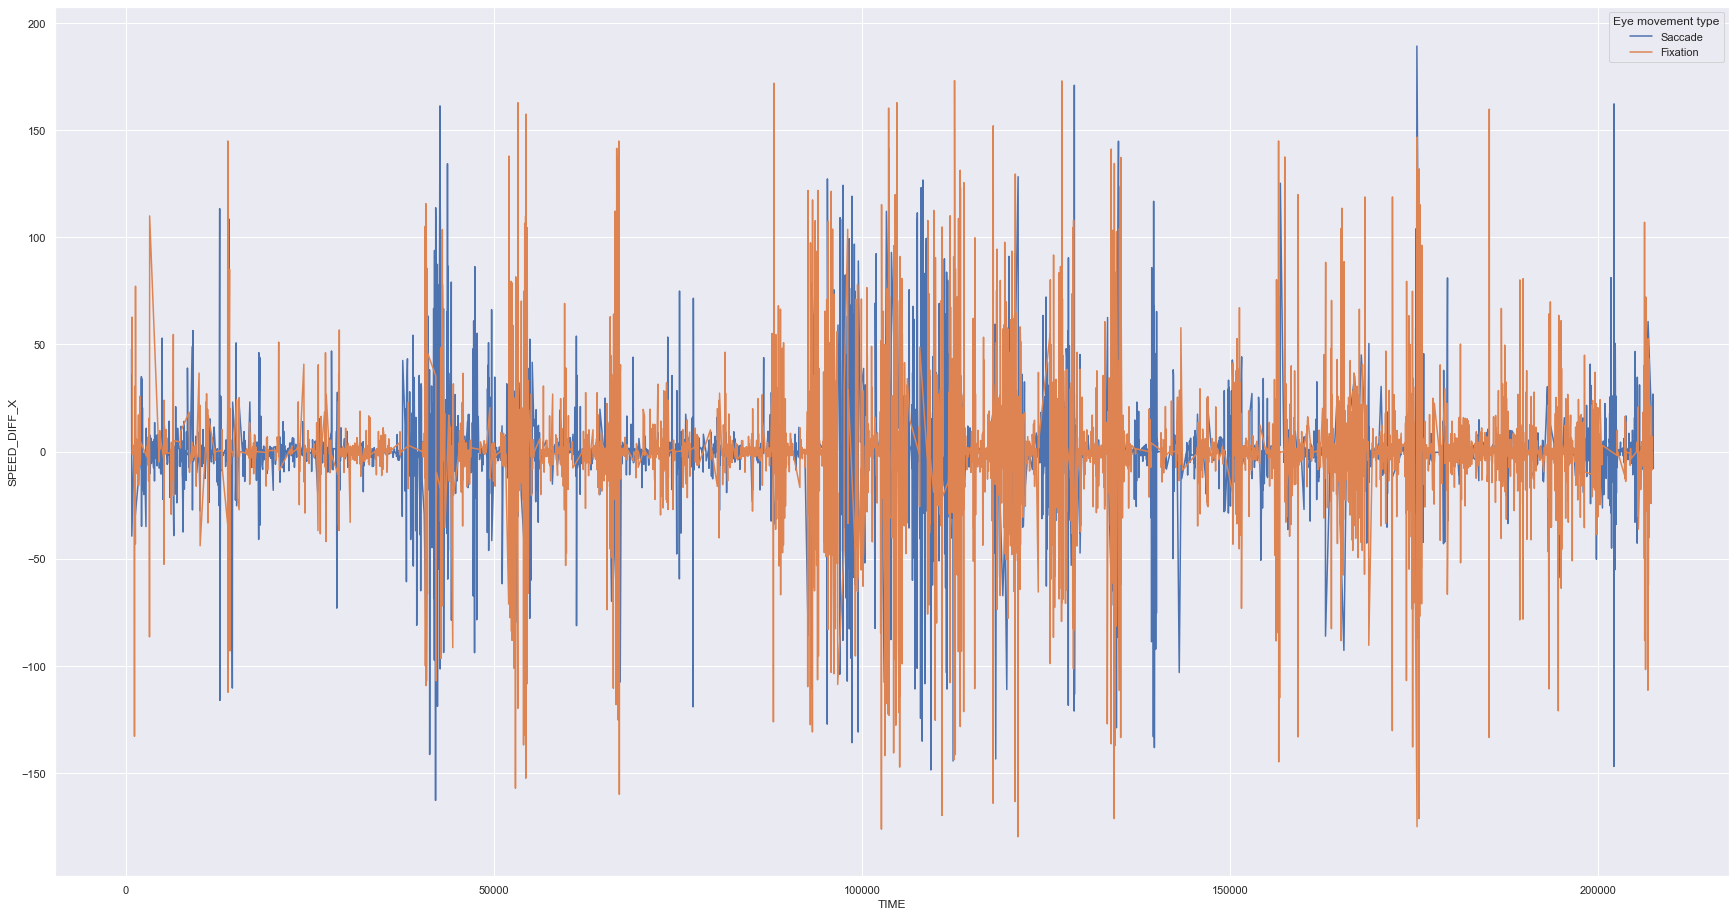

In [4]:

sns.lineplot(x=data['TIME'], y=data['SPEED_DIFF_X'], hue=data['Eye movement type'])

<AxesSubplot:xlabel='TIME', ylabel='SPEED_DIFF_Y'>

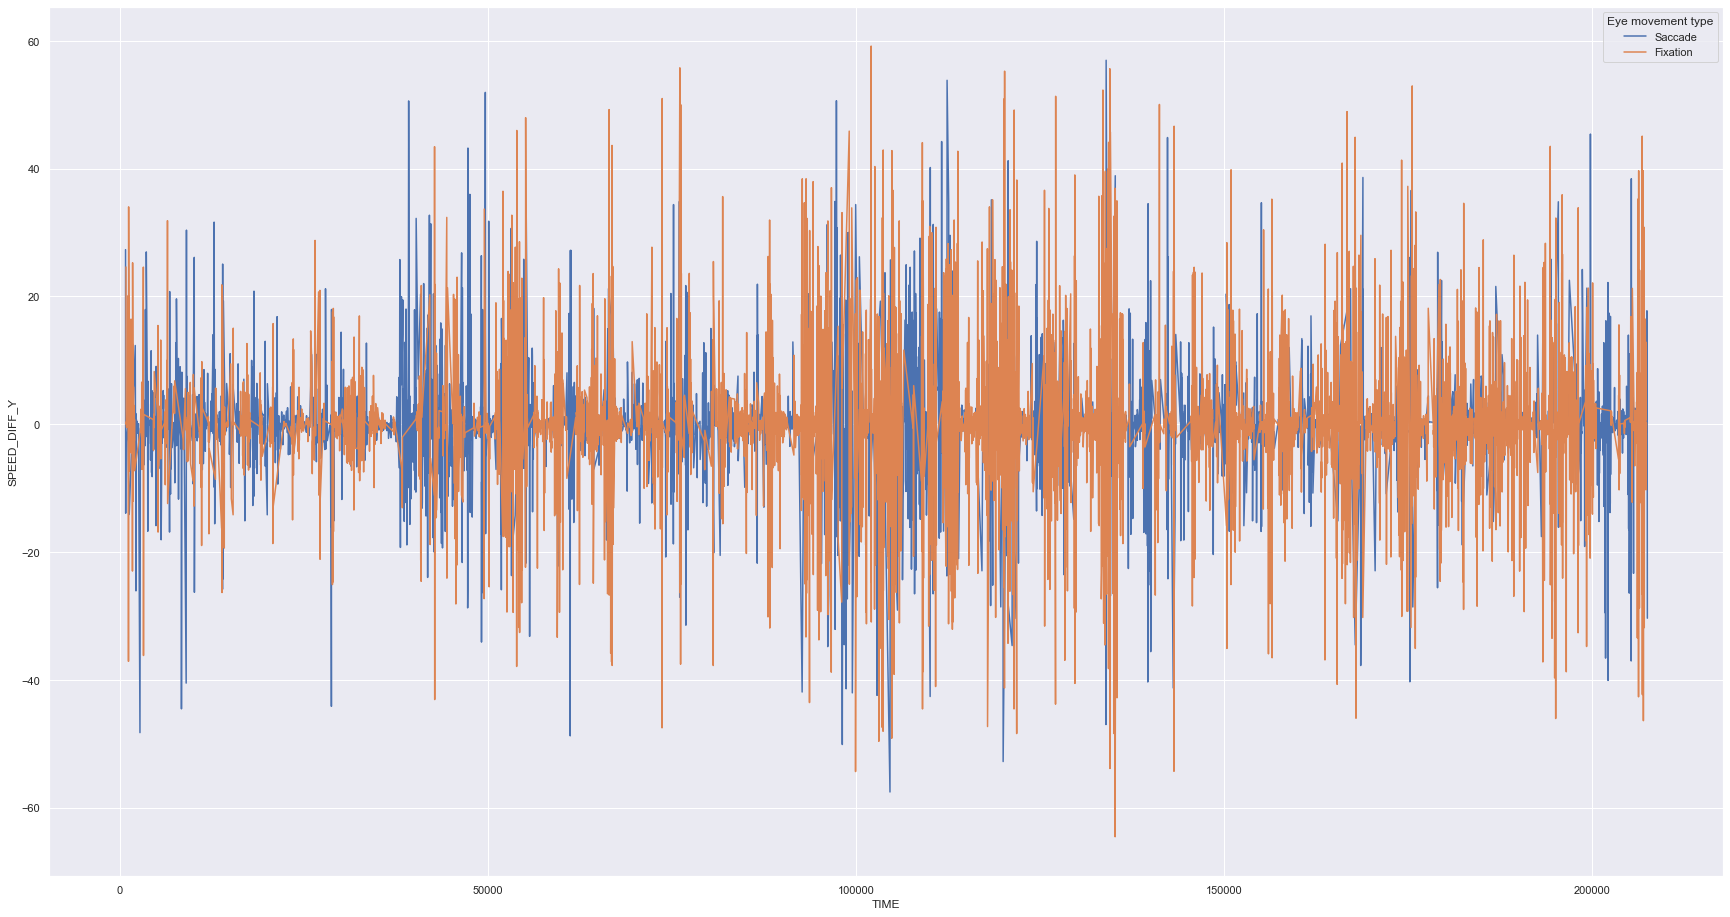

In [5]:
sns.lineplot(x=data['TIME'], y=data['SPEED_DIFF_Y'], hue=data['Eye movement type'])

<AxesSubplot:xlabel='SPEED_DIFF_X', ylabel='SPEED_DIFF_Y'>

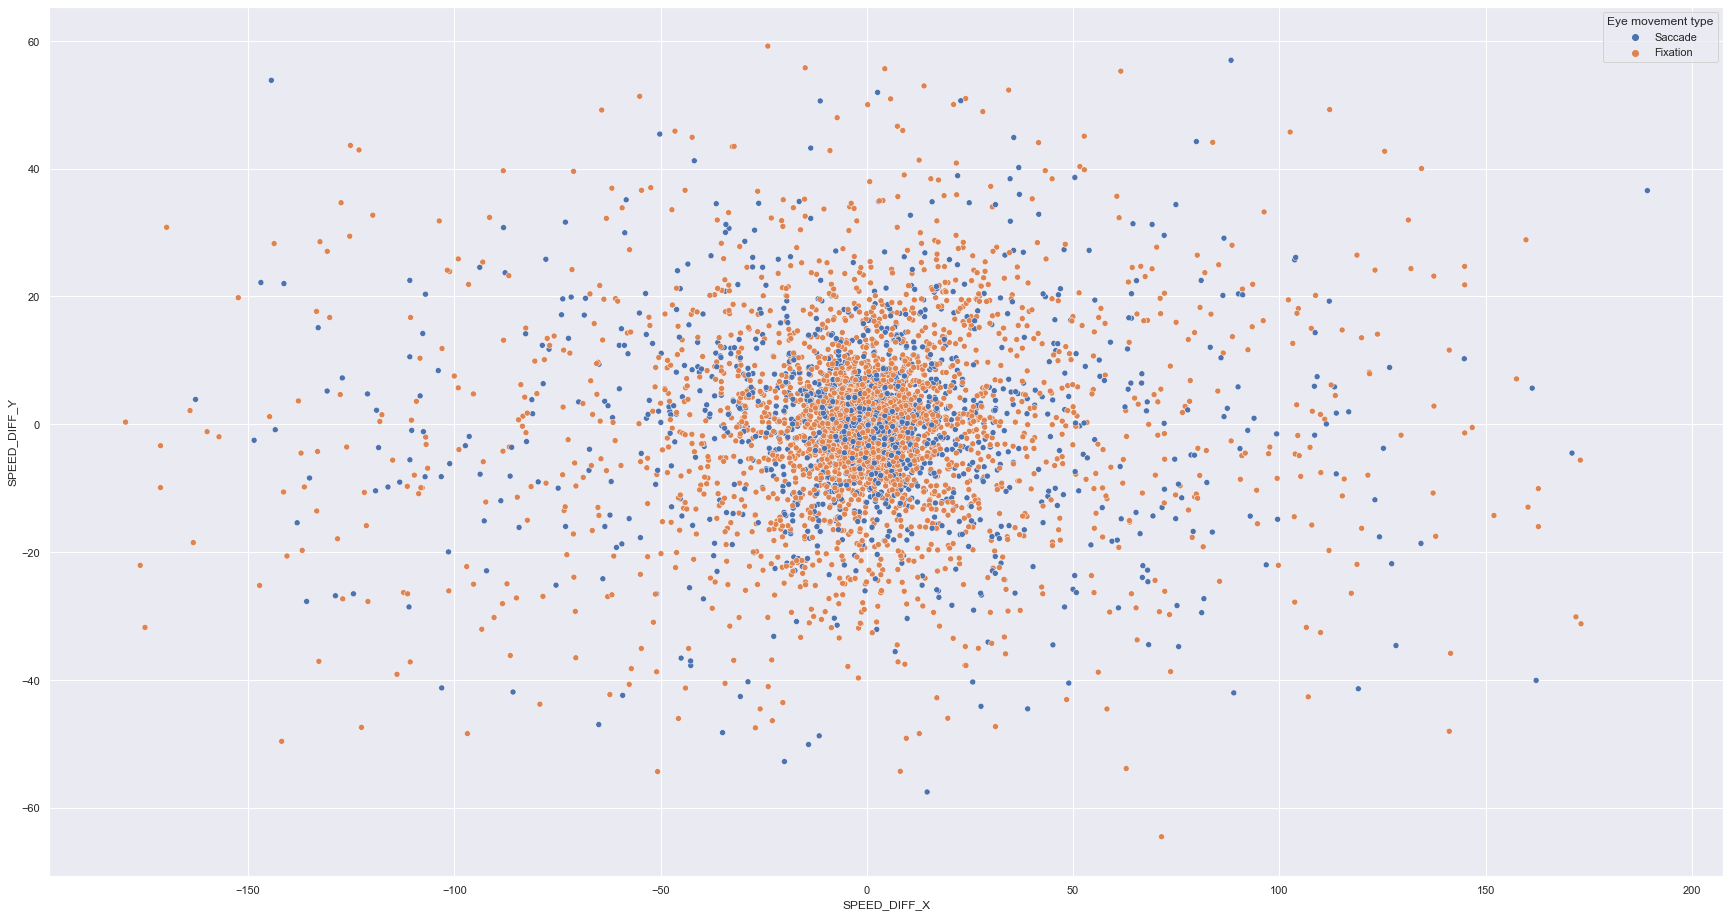

In [6]:
sns.scatterplot(x=data['SPEED_DIFF_X'], y=data['SPEED_DIFF_Y'], hue=data['Eye movement type'])

In [7]:
data['Eye movement type'] = data['Eye movement type'].replace('Fixation', 1)
data['Eye movement type'] = data['Eye movement type'].replace('Saccade', 0)

c:\Users\Arthur\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Eye movement type', ylabel='count'>

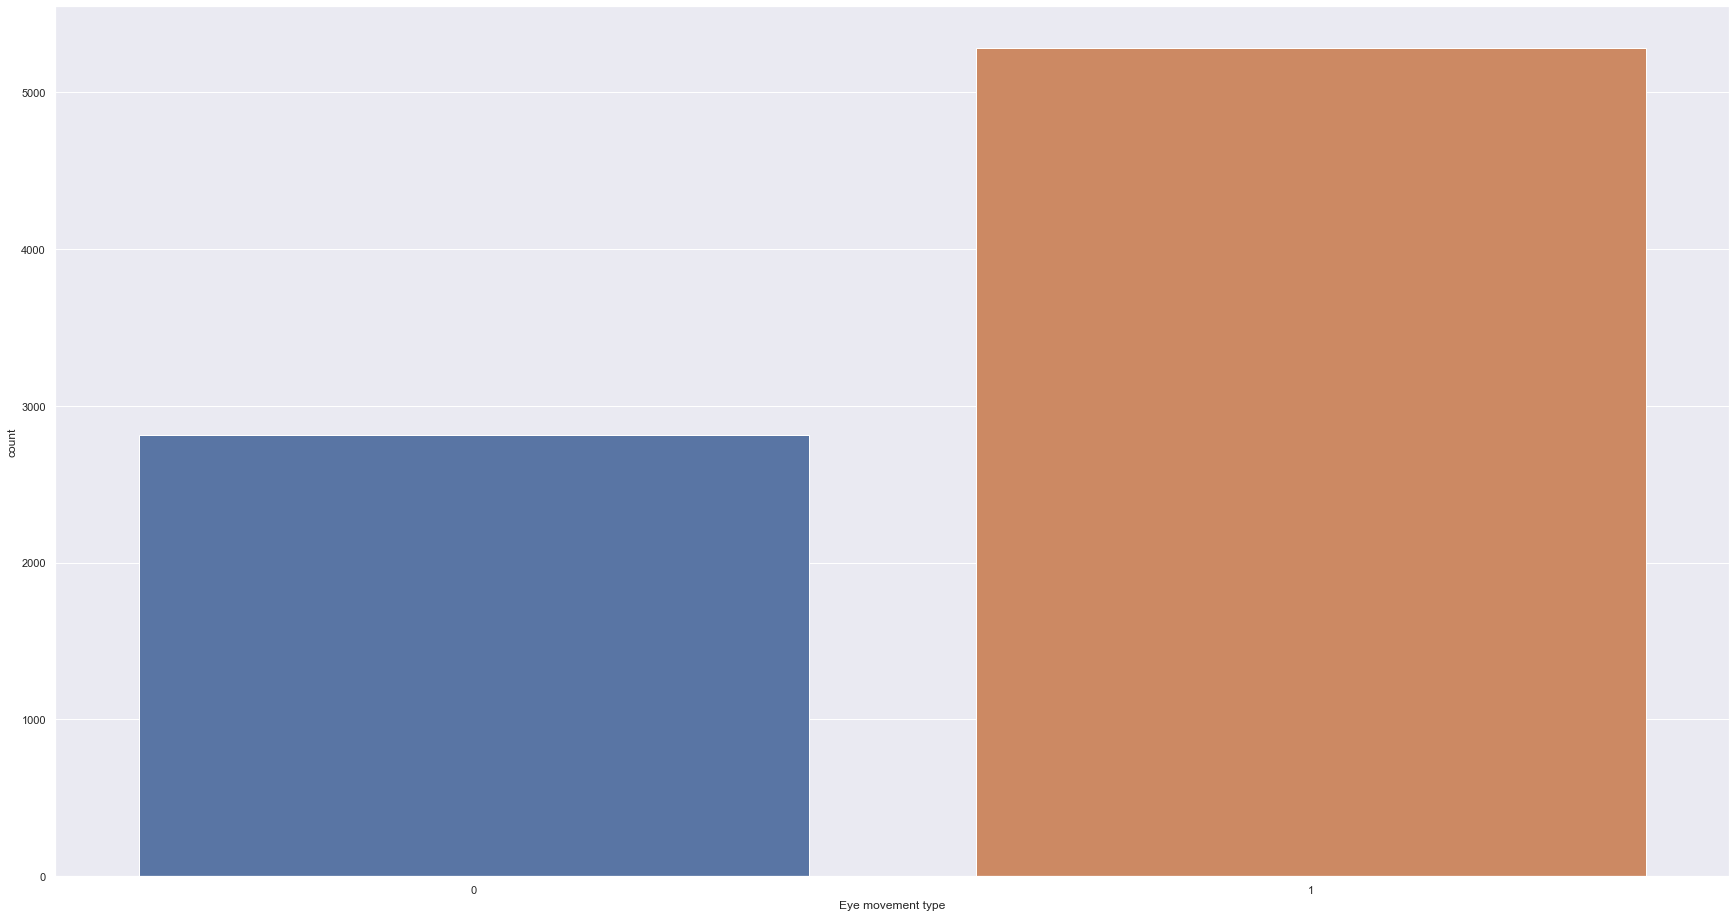

In [8]:
sns.countplot(data['Eye movement type'])

In [9]:
data.columns

X = data.drop(['Eye movement type', 'Recording timestamp', 'TIME', 'PREV_TIME'], axis=1)
Y = data['Eye movement type']

In [10]:
scaler = StandardScaler()

X = scaler.fit_transform(X)

In [11]:
X_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=0)

In [12]:
regr = LogisticRegression()
regr.fit(X_train, y_train)

LogisticRegression()

In [13]:
y_pred = regr.predict(x_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.09      0.58      0.15       105
           1       0.97      0.67      0.79      1920

    accuracy                           0.67      2025
   macro avg       0.53      0.63      0.47      2025
weighted avg       0.92      0.67      0.76      2025



In [14]:
svc_model = SVC(kernel='linear', random_state=0)
svc_model.fit(X_train, y_train)

SVC(kernel='linear', random_state=0)

In [15]:
y_pred = svc_model.predict(x_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.66      0.80      2025

    accuracy                           0.66      2025
   macro avg       0.50      0.33      0.40      2025
weighted avg       1.00      0.66      0.80      2025



c:\Users\Arthur\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Arthur\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Arthur\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

<AxesSubplot:>

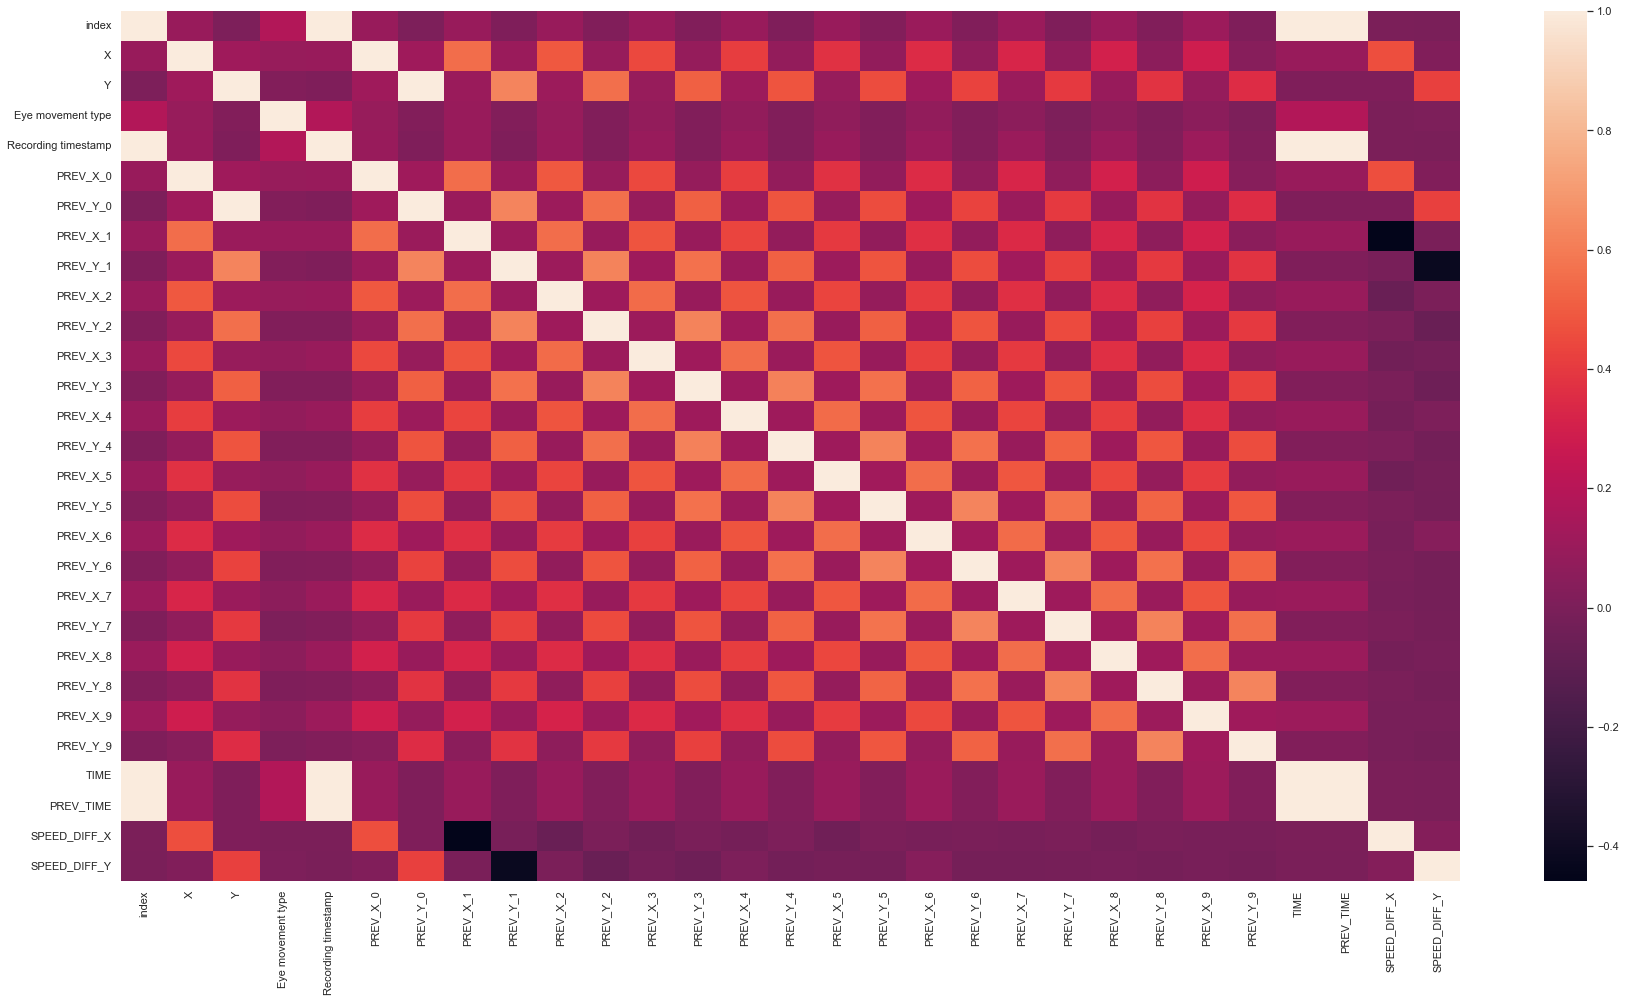

In [16]:
sns.heatmap(data.corr())

In [17]:
data.describe()

,index,X,Y,Eye movement type,Recording timestamp,PREV_X_0,PREV_Y_0,PREV_X_1,PREV_Y_1,PREV_X_2,...,PREV_X_7,PREV_Y_7,PREV_X_8,PREV_Y_8,PREV_X_9,PREV_Y_9,TIME,PREV_TIME,SPEED_DIFF_X,SPEED_DIFF_Y
count,8100.000000,8100.000000,8100.000000,8100.000000,8100.000000,8100.000000,8100.000000,8100.000000,8100.000000,8100.000000,...,8100.000000,8100.000000,8100.000000,8100.000000,8100.000000,8100.000000,8100.000000,8100.000000,8100.000000,8100.000000
mean,4856.867160,2675.284321,855.992346,0.652346,107291.162350,2675.284321,855.992346,2673.153827,855.422099,2674.212840,...,2674.279383,854.401235,2671.356296,852.813086,2669.904815,853.693210,107291.162350,107268.220053,0.015473,0.017138
std,2728.436819,643.178732,258.306770,0.476255,59040.595973,643.178732,258.306770,644.523379,258.689801,645.044018,...,645.101448,258.868924,646.426907,259.303672,645.238290,258.185777,59040.595973,59040.883552,28.242973,10.404363
min,24.000000,1.000000,1.000000,0.000000,759.577000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,759.577000,739.600000,-179.729730,-64.541912
25%,2512.750000,2453.000000,709.000000,0.000000,57182.132000,2453.000000,709.000000,2451.000000,708.000000,2451.000000,...,2449.750000,707.750000,2449.000000,707.000000,2448.000000,707.750000,57182.132000,57162.146000,-3.064589,-2.152044
50%,4897.000000,2695.000000,816.500000,1.000000,108497.585500,2695.000000,816.500000,2694.000000,816.500000,2695.000000,...,2694.000000,815.000000,2693.000000,814.000000,2692.000000,815.000000,108497.585500,108477.585500,0.000000,0.000000
75%,7242.250000,3008.000000,1045.000000,1.000000,159333.256250,3008.000000,1045.000000,3002.000000,1045.000000,3007.000000,...,3009.000000,1044.000000,3003.250000,1044.000000,3002.000000,1044.000000,159333.256250,159313.273750,3.002064,2.101287
max,9504.000000,4222.000000,1559.000000,1.000000,207480.452000,4222.000000,1559.000000,4222.000000,1559.000000,4222.000000,...,4212.000000,1559.000000,4222.000000,1559.000000,4212.000000,1559.000000,207480.452000,207460.446000,189.222995,59.185511
